In [1]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 13.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
project_path = "/content/drive/MyDrive/SIGN/"

In [4]:
import pandas as pd

import cv2
from google.colab.patches import cv2_imshow
import mediapipe as mp
import numpy as np
from mediapipe.python.solutions.pose import PoseLandmark
from mediapipe.python.solutions.drawing_utils import DrawingSpec
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh =  mp.solutions.face_mesh
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

from mediapipe.framework.formats.landmark_pb2 import LandmarkList, Landmark

# Testing Media Pipe Processed Data

In [5]:
def extract_frames(video_path, SEQUENCE_LENGTH=None):
  """
    Extracts the required frames from after resizing and normalizing them.
    Args:
      video_path: File path of the video to be processed.
    Returns:
      A numpy array containing the extracted frames.
  """
  result = []

  # Read the video file using VideoCapture object
  src = cv2.VideoCapture(str(video_path))

  # Retrieve frame count from VideoCapture object
  video_frame_count = int(src.get(cv2.CAP_PROP_FRAME_COUNT))

  if SEQUENCE_LENGTH:

    # Calculate the frame interval to skip frames and add to the result
    skip_frames_window = max(int(video_frame_count/SEQUENCE_LENGTH), 1)

    for counter in range(SEQUENCE_LENGTH):

      # Set current frame position
      src.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_frames_window)

      ret, frame = src.read()

      # Check if the frame video was successfully read. If not, break.
      if not ret:
        break

      result.append(frame)

  else:
    for counter in range(video_frame_count):

      # Set current frame position
      src.set(cv2.CAP_PROP_POS_FRAMES, counter)

      ret, frame = src.read()

      if not ret:
        break

      result.append(frame)

  # Releace VideoCapture object
  src.release()

  return result

In [6]:
# Load video from MP4 format to array of frames
frames = extract_frames(project_path+"Dataset/Bem/Bem_9test.MP4")

In [7]:
# Load previously processed landmarks from the video
landmarks_df = pd.read_parquet(project_path+"Dataset_processed/test/Bem/Bem_9test.parquet")

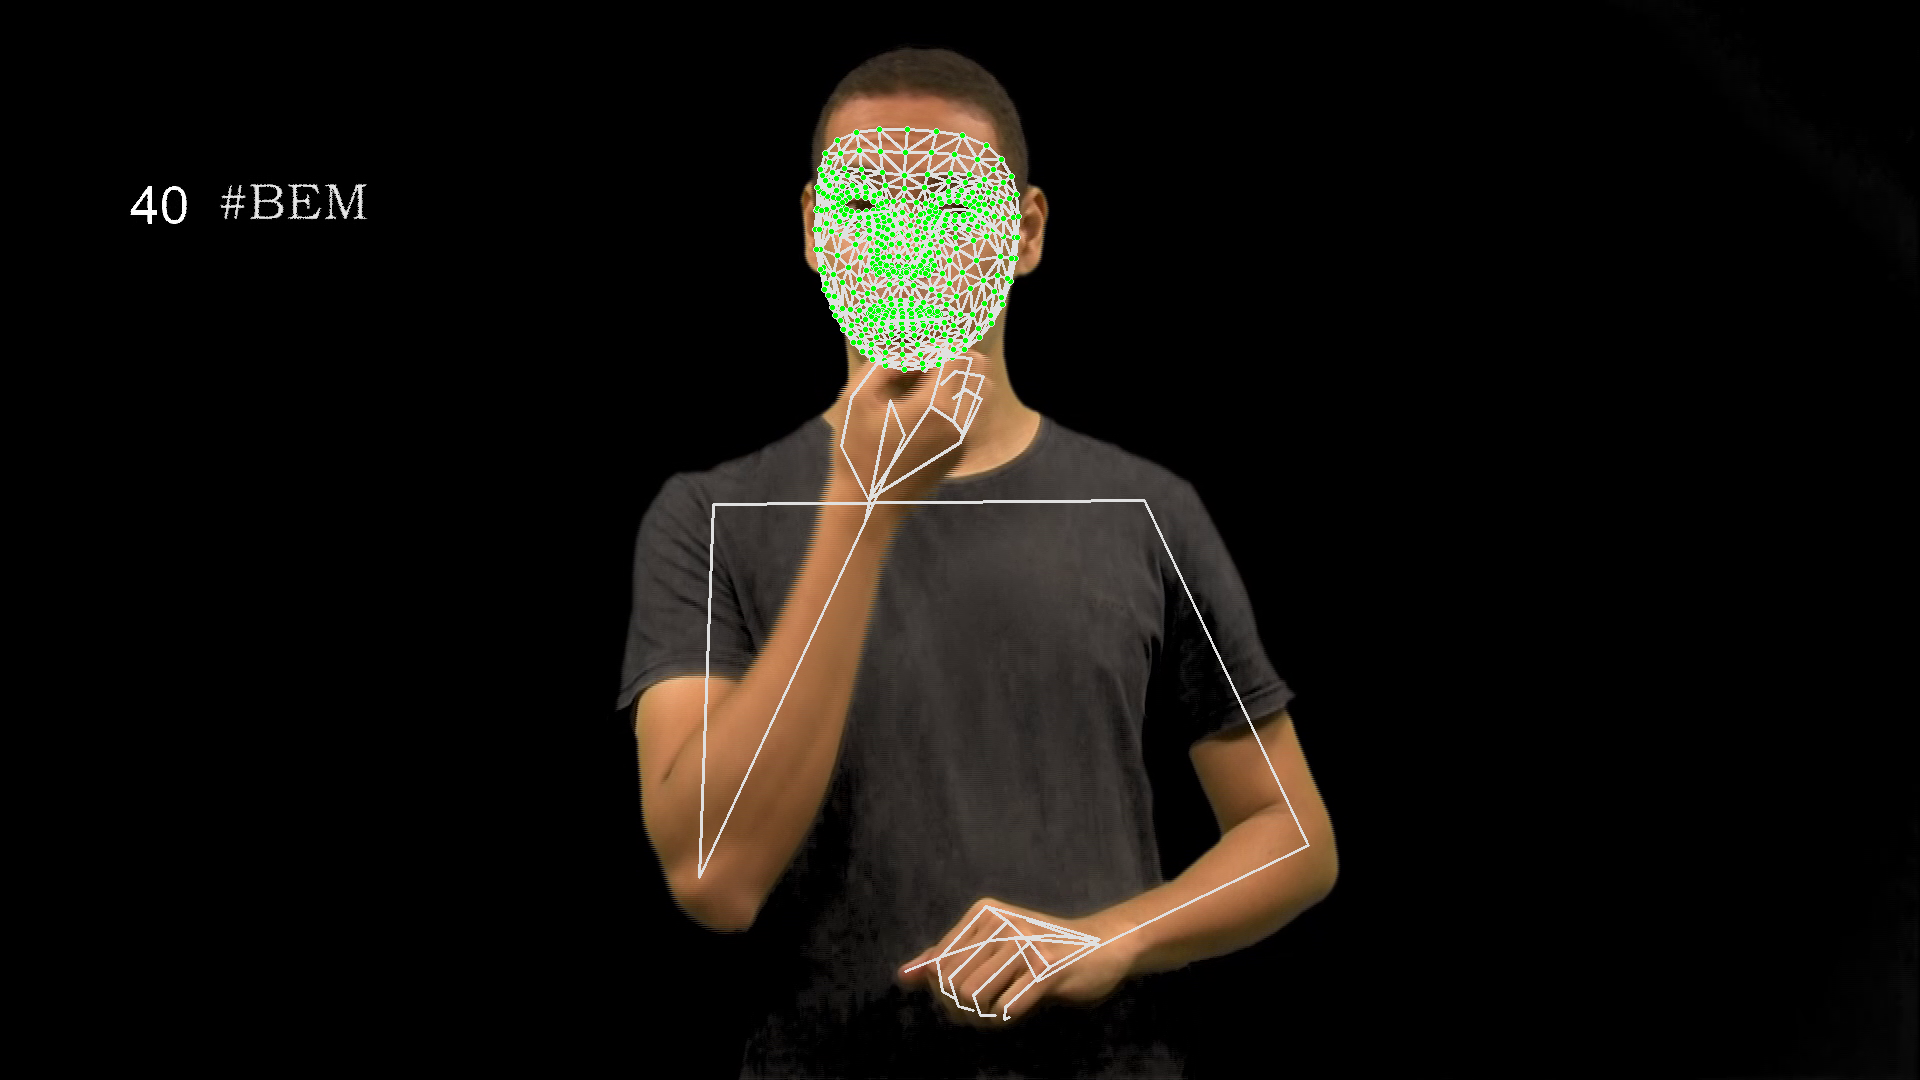

In [11]:
# CHANGE VALUE TO SEE OTHER FRAMES
frame_number = 40

# Filter landmarks for a specigic frame
filtered_landmarks = landmarks_df[landmarks_df["frame"]==frame_number]

actual_frame = frames[frame_number]
image = cv2.cvtColor(actual_frame, cv2.COLOR_BGR2RGB)
image.flags.writeable = True

landmark_types = filtered_landmarks["type"].unique()

for landmark_type in landmark_types:

  type_landmarks = filtered_landmarks[filtered_landmarks["type"]==landmark_type]

  landmarks = []

  for _, row in type_landmarks.iterrows():
    landmarks.append(
        Landmark(
            x=row["x"],
            y=row["y"],
            z=row["z"]
        )
    )
  landmark_list = LandmarkList(landmark=landmarks)

  # Determine the appropriate connections (e.g., face, pose, hand)
  if landmark_type == "face":
    connections = mp_face_mesh.FACEMESH_TESSELATION  # Use FACEMESH_TESSELATION for face
  elif landmark_type == "pose":
      connections = mp_pose.POSE_CONNECTIONS  # Use POSE_CONNECTIONS for pose
  elif landmark_type == "left_hand":
      connections = mp_hands.HAND_CONNECTIONS  # Use HAND_CONNECTIONS for hands
  elif landmark_type == "right_hand":
      connections = mp_hands.HAND_CONNECTIONS  # Use HAND_CONNECTIONS for hands
  else:
      connections = None  # For unsupported types, skip connections

  # Draw the landmarks on the image
  mp_drawing.draw_landmarks(
      image,
      landmark_list,
      connections,
      landmark_drawing_spec= mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=1)
      if landmark_type == "face"
      else None,
  )

img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2_imshow(img_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()